In [2]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO
import os
import shutil
import xml.etree.ElementTree as ET
from pathlib import Path
from sklearn.model_selection import train_test_split

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip "/content/drive/MyDrive/NTI - Project/VOC2028.zip"

Streaming output truncated to the last 5000 lines.
  inflating: VOC2028/JPEGImages/part2_001435.jpg  
  inflating: VOC2028/JPEGImages/part2_001437.jpg  
  inflating: VOC2028/JPEGImages/part2_001438.jpg  
  inflating: VOC2028/JPEGImages/part2_001445.jpg  
  inflating: VOC2028/JPEGImages/part2_001446.jpg  
 extracting: VOC2028/JPEGImages/part2_001448.jpg  
  inflating: VOC2028/JPEGImages/part2_001451.jpg  
  inflating: VOC2028/JPEGImages/part2_001452.jpg  
  inflating: VOC2028/JPEGImages/part2_001453.jpg  
  inflating: VOC2028/JPEGImages/part2_001454.jpg  
  inflating: VOC2028/JPEGImages/part2_001455.jpg  
  inflating: VOC2028/JPEGImages/part2_001457.jpg  
  inflating: VOC2028/JPEGImages/part2_001458.jpg  
  inflating: VOC2028/JPEGImages/part2_001459.jpg  
  inflating: VOC2028/JPEGImages/part2_001462.jpg  
  inflating: VOC2028/JPEGImages/part2_001464.jpg  
  inflating: VOC2028/JPEGImages/part2_001466.jpg  
  inflating: VOC2028/JPEGImages/part2_001467.jpg  
  inflating: VOC2028/JPEGImages

In [6]:

#CONFIGURATION
CLASSES = {"hat": 0, "head": 1, "person": 2}  # Classes
# POINT TO data  FOLDERS
RAW_IMAGES_DIR = Path("/content/VOC2028/JPEGImages")
RAW_LABELS_DIR = Path("/content/VOC2028/Annotations")
OUTPUT_DIR = Path("yolo_ready_dataset")

def convert_xml_to_yolo(xml_path, img_w, img_h):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    yolo_lines = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        if name not in CLASSES: continue

        bnd = obj.find("bndbox")
        xmin = float(bnd.find("xmin").text)
        ymin = float(bnd.find("ymin").text)
        xmax = float(bnd.find("xmax").text)
        ymax = float(bnd.find("ymax").text)

        # The Math
        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        w = (xmax - xmin) / img_w
        h = (ymax - ymin) / img_h

        yolo_lines.append(f"{CLASSES[name]} {x_center} {y_center} {w} {h}")

    return yolo_lines

def process_dataset():
    # 1. Setup Directories
    for split in ['train', 'val']:
        (OUTPUT_DIR / split / 'images').mkdir(parents=True, exist_ok=True)
        (OUTPUT_DIR / split / 'labels').mkdir(parents=True, exist_ok=True)

    # 2. Get all images from the image directory
    images = list(RAW_IMAGES_DIR.glob("*.jpg")) + list(RAW_IMAGES_DIR.glob("*.png")) + list(RAW_IMAGES_DIR.glob("*.jpeg"))

    if not images:
        print("Error: No images found! Check RAW_IMAGES_DIR path.")
        return

    # 3. Split 80/20
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # 4. Process Loop
    for split, img_list in [('train', train_imgs), ('val', val_imgs)]:
        for img_path in img_list:


            xml_filename = img_path.stem + ".xml"
            xml_path = RAW_LABELS_DIR / xml_filename

            if not xml_path.exists():
                print(f"Skipping {img_path.name} - No matching XML found.")
                continue

            shutil.copy(img_path, OUTPUT_DIR / split / 'images' / img_path.name)

            # Convert Label
            try:
                tree = ET.parse(xml_path)
                size = tree.find("size")
                width = float(size.find("width").text)
                height = float(size.find("height").text)

                lines = convert_xml_to_yolo(xml_path, width, height)

                # Save Label
                label_path = OUTPUT_DIR / split / 'labels' / (img_path.stem + ".txt")
                with open(label_path, 'w') as f:
                    f.write('\n'.join(lines))
            except Exception as e:
                print(f"Error parsing {xml_path}: {e}")

    # 5. Create data.yaml automatically
    yaml_content = f"""
    path: {OUTPUT_DIR.absolute()}
    train: train/images
    val: val/images
    names: {list(CLASSES.keys())}
    """
    with open(OUTPUT_DIR / "data.yaml", "w") as f:
        f.write(yaml_content)

    print("Dataset Ready!")

# --- RUN EVERYTHING ---
process_dataset()



Dataset Ready!


In [7]:
# --- TRAIN ---
model = YOLO('yolov8n.pt')
model.train(data=str(OUTPUT_DIR / "data.yaml"), epochs=20, imgsz=640)

Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_ready_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e2c402eb530>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [9]:
# --- EVALUATION FUNCTION ---
def print_research_metrics(model_path, dataset_yaml, dataset_name):
    print(f"Evaluating {dataset_name} with {model_path}")
    model = YOLO(model_path)

    # Run validation
    metrics = model.val(data=dataset_yaml, verbose=False)

    # Extract key numbers
    map50 = metrics.box.map50
    map50_95 = metrics.box.map
    precision = metrics.box.mp
    recall = metrics.box.mr

    print(f"mAP@50 (Accuracy):      {map50:.3f}")
    print(f"mAP@50-95 (Precision):  {map50_95:.3f}")
    print(f"Precision:              {precision:.3f}")
    print(f"Recall:                 {recall:.3f}")

    return map50


# 1. Evaluate Baseline on Dataset A (Source)
score_A = print_research_metrics(
    '/content/runs/detect/train/weights/best.pt',
    '/content/yolo_ready_dataset/data.yaml',
    'Dataset A (Source)'
)

# 2. Evaluate Baseline on Dataset B (Target - if you have it)
# score_B = print_research_metrics(...)

# 3. Calculate Drop (for your paper)
# drop = ((score_A - score_B) / score_A) * 100
# print(f"Performance Drop: {drop:.1f}%")

Evaluating Dataset A (Source) with /content/runs/detect/train/weights/best.pt
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1350.7±852.1 MB/s, size: 168.1 KB)
val: Scanning /content/yolo_ready_dataset/val/labels.cache... 1515 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1515/1515 2.0Mit/s 0.0s
val: /content/yolo_ready_dataset/val/images/000006.jpg: corrupt JPEG restored and saved
val: /content/yolo_ready_dataset/val/images/000061.jpg: corrupt JPEG restored and saved
val: /content/yolo_ready_dataset/val/images/000068.jpg: corrupt JPEG restored and saved
val: /content/yolo_ready_dataset/val/images/000106.jpg: corrupt JPEG restored and saved
val: /content/yolo_ready_dataset/val/images/000267.jpg: corrupt JPEG restored and saved
val: /content/yolo_ready_dataset/val/images/000268.jpg: corrupt JPEG restored and saved
val


image 1/1 /content/001437.jpg: 640x448 1 hat, 40.6ms
Speed: 3.4ms preprocess, 40.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


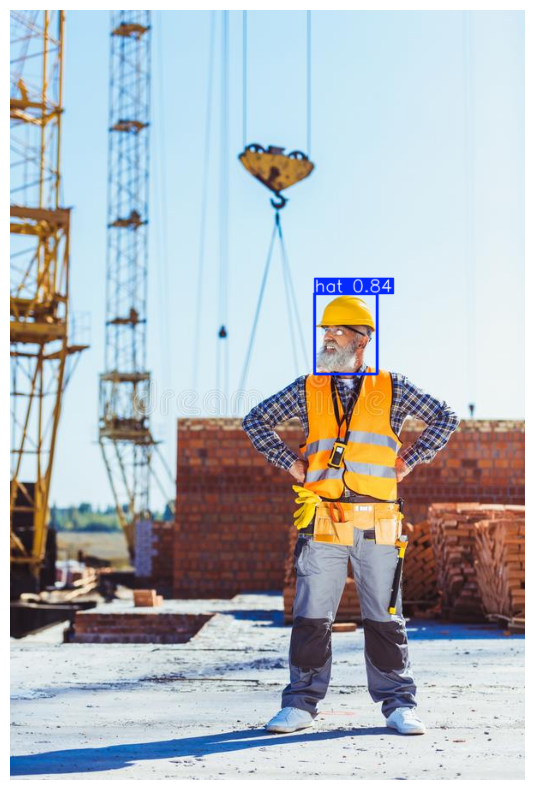

In [11]:
import cv2
import matplotlib.pyplot as plt
model = YOLO('runs/detect/train/weights/best.pt')
image_path = '/content/001437.jpg'
results = model.predict(source=image_path, conf=0.25)
result_img_bgr = results[0].plot()
result_img_rgb = cv2.cvtColor(result_img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(result_img_rgb)
plt.axis('off')
plt.show()


image 1/1 /content/blog-construction.jpg: 480x640 3 hats, 38.5ms
Speed: 2.6ms preprocess, 38.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict


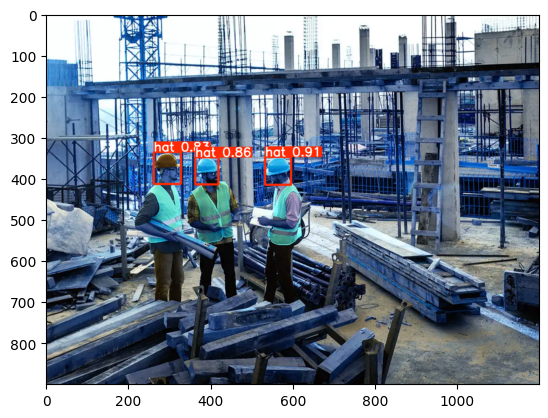

In [12]:
# Change conf from 0.25 to 0.01 (1%) to see EVERYTHING
results = model.predict(source='/content/blog-construction.jpg', conf=0.50, save=True)

# Plot it to see if faint boxes appear
import matplotlib.pyplot as plt
plt.imshow(results[0].plot())
plt.show()

In [13]:
ls

001437.jpg             drive/  sample_data/  yolo11n.pt           yolov8n.pt
blog-construction.jpg  runs/   VOC2028/      yolo_ready_dataset/


In [14]:
import shutil
shutil.make_archive("runs", 'zip', "runs")

'/content/runs.zip'

In [15]:
shutil.make_archive("yolo_ready_dataset", 'zip', "yolo_ready_dataset")

'/content/yolo_ready_dataset.zip'